#  Data preprocessing

### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F

import torch
import os 
from os import listdir


In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
base_dir = os.getcwd()

In [4]:
data_dir = os.path.join(base_dir, 'data')
output_dir = os.path.join(base_dir, 'outputs')
processed_data_dir = os.path.join(base_dir, 'processed_data')
files = listdir(data_dir)

print(len(files))

280


### Importing Data

In [5]:
train_file_path = os.path.join(processed_data_dir, 'train_df.pkl')
test_file_path =  os.path.join(processed_data_dir, 'test_df.pkl')
dev_file_path =  os.path.join(processed_data_dir, 'dev_df.pkl')

In [6]:
train_df = pd.read_pickle(train_file_path)
test_df = pd.read_pickle(test_file_path)
dev_df = pd.read_pickle(dev_file_path)

### Useful Function(s)

In [7]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

### Data Preprocessing

In [8]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [9]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [10]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

### Printing Processed Images 

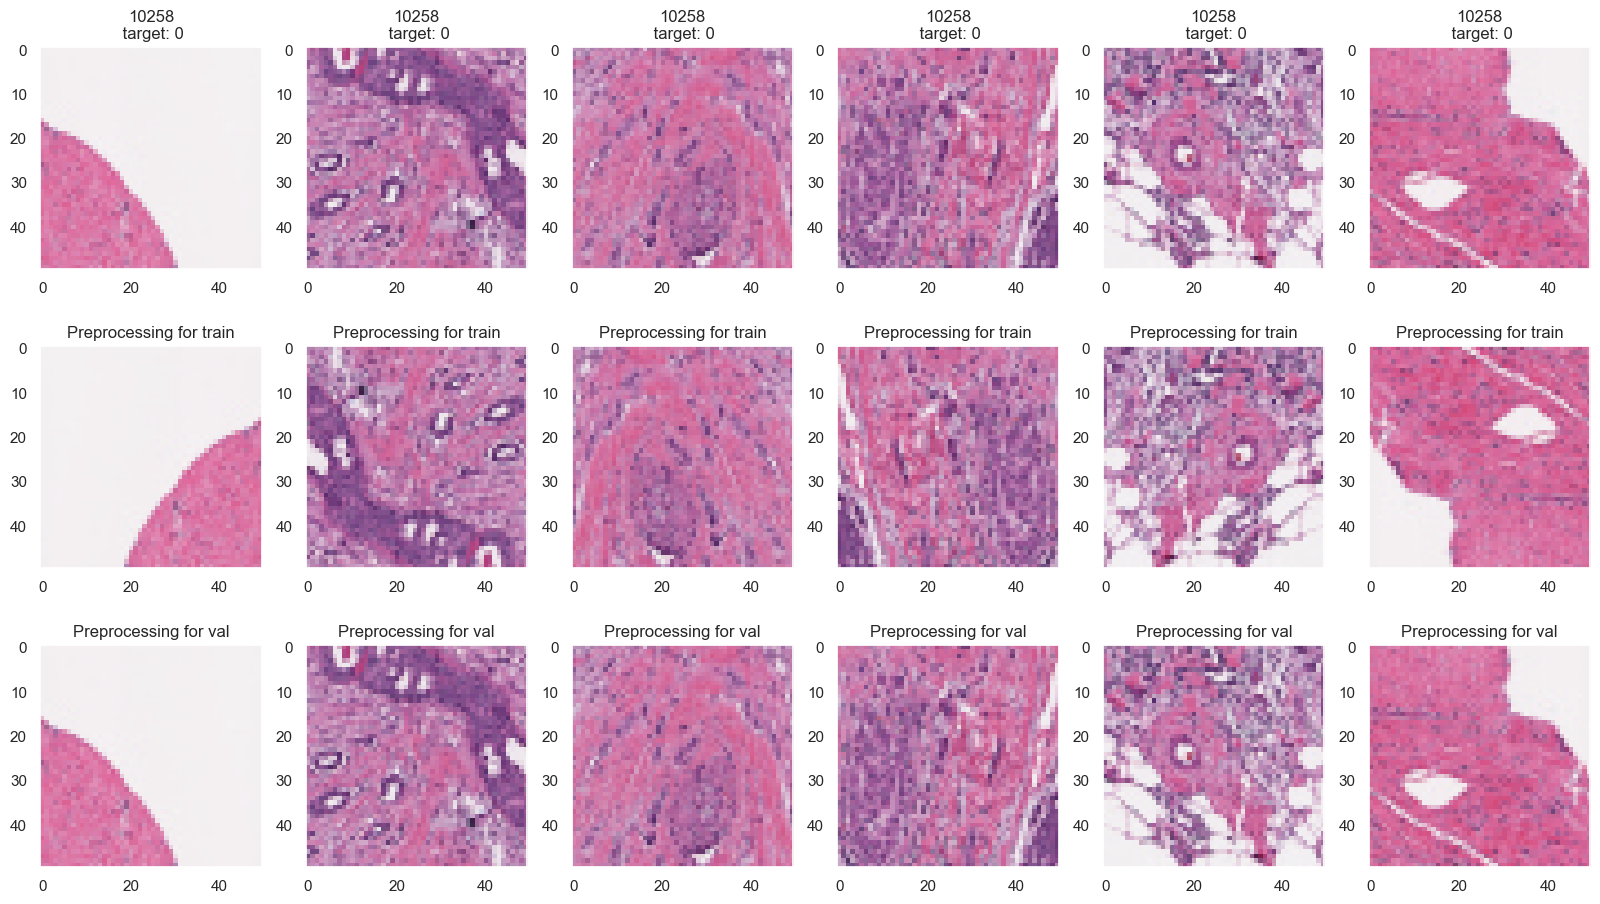

In [11]:
fig, ax = plt.subplots(3,6,figsize=(20,11))

train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    filepath = train_df.path.values[m]
    image = Image.open(filepath)
    ax[0,m].imshow(image)
    transformed_img = train_transform(image)
    ax[1,m].imshow(transformed_img)
    ax[2,m].imshow(val_transform(image))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[2,m].grid(False)
    ax[0,m].set_title(train_df.patient_id.values[m] + "\n target: " + train_df.target.values[m])
    ax[1,m].set_title("Preprocessing for train")
    ax[2,m].set_title("Preprocessing for val")

title = 'Data augmentation'
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()